# Integration of NEP Samples (v1)

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import scvi
import scanpy as sc
import sc_utils
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import sankey

Global seed set to 0


## Read in data

In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
# Correspondence between study IDs and sample IDs
id_map = pd.read_csv(f"{data_dir}/clinical/NEP_study_sample_id_map.csv")
# List of all NEP samples
NEP_SC_ids = id_map["NEP scRNAseq ID"].tolist()
len(NEP_SC_ids)

13

In [4]:
# Read in BAL count matrices and add metadata
datasets = []
for i in range(len(NEP_SC_ids)):
    ddir = f"{data_dir}/NEP_exon_only/{NEP_SC_ids[i]}/filtered_feature_bc_matrix/"
    datasets.append(sc.read_10x_mtx(path = ddir))
    
    # Record study ID
    datasets[i].obs["Study ID"] = id_map["Study ID"][i]
    
    # Note whether sample is PASC or healthy control
    datasets[i].obs["is_PASC"] = (id_map["Study ID"][i][0:4] == "PASC")
    datasets[i].obs["is_PASC"] = datasets[i].obs["is_PASC"].astype(str).astype('category')
    
    # Trim gene names
    datasets[i].var_names = [x.split("GRCh38_")[-1] for x in datasets[i].var_names]

## Merge datasets

In [5]:
adata = datasets[0].concatenate(datasets[1:], join = "outer", batch_key = "SC ID", batch_categories = NEP_SC_ids)
adata

AnnData object with n_obs × n_vars = 84059 × 36613
    obs: 'Study ID', 'is_PASC', 'SC ID'
    var: 'gene_ids', 'feature_types'

## Run library-wise QC

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

In [ ]:
mpl.rcParams["figure.figsize"] = (15, 5)
sc.pl.violin(adata, "n_genes_by_counts", groupby = "SC ID")

In [ ]:
mpl.rcParams["figure.figsize"] = (15, 5)
sc.pl.violin(adata, "total_counts", groupby = "SC ID")

## Filter lowly expressed genes

In [9]:
sc.pp.filter_genes(adata, min_counts = 3)
sc.pp.filter_cells(adata, min_genes = 1)
adata

AnnData object with n_obs × n_vars = 84056 × 27534
    obs: 'Study ID', 'is_PASC', 'SC ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts'
    uns: 'SC ID_colors'

## Remove library with large percentage of HBB+ cells

In [ ]:
sc.pl.dotplot(adata, ["HBB"], groupby = "Study ID")

In [11]:
adata = adata[adata.obs["Study ID"] != "HV14"].copy()

## Save raw object

In [12]:
adata_raw = adata.copy()
adata_raw.write(f"{data_dir}/NEP_exon_only/raw/adata_raw.h5ad")

## Normalize data

In [13]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

## Feature selection

In [14]:
# Keep only top 1000 highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes = 1000,
    subset = True,
    batch_key = "SC ID"
)
# Remove cells with zero expression across HVGs
sc.pp.filter_cells(adata, min_genes = 1)
adata

AnnData object with n_obs × n_vars = 71695 × 1000
    obs: 'Study ID', 'is_PASC', 'SC ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'SC ID_colors', 'log1p', 'hvg'
    layers: 'counts'

## Create scVI model

In [15]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts", batch_key = "SC ID")
model_adata = scvi.model.SCVI(adata, n_layers = 2, dropout_rate = 0.2, n_latent = 10)
model_adata.save(f"{data_dir}/NEP_exon_only/models/", overwrite = True, save_anndata = True)

## Train model

In [16]:
## The model is trained on a Quest GPU node. ##

In [17]:
model_adata = scvi.model.SCVI.load(f"{data_dir}/NEP_exon_only/models/", adata, prefix = "trained")

INFO     File /projects/b1038/Pulmonary/cpuritz/PASC/data/NEP_exon_only/models/trainedmodel.pt already downloaded  


## Store scVI outputs in original anndata

In [18]:
adata.obsm["X_scVI"] = model_adata.get_latent_representation()

## Store normalized values back in the anndata

In [19]:
adata.layers["scvi_normalized"] = model_adata.get_normalized_expression()

## Use scVI latent space for UMAP generation

In [20]:
# Compute neighborhood graph
sc.pp.neighbors(adata, use_rep = "X_scVI")

In [21]:
# Embed neighborhood graph using UMAP
sc.tl.umap(adata, min_dist = 0.3)

In [22]:
# Perform Leiden clustering
sc.tl.leiden(adata, key_added = "leiden_scVI", resolution = 0.75)

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


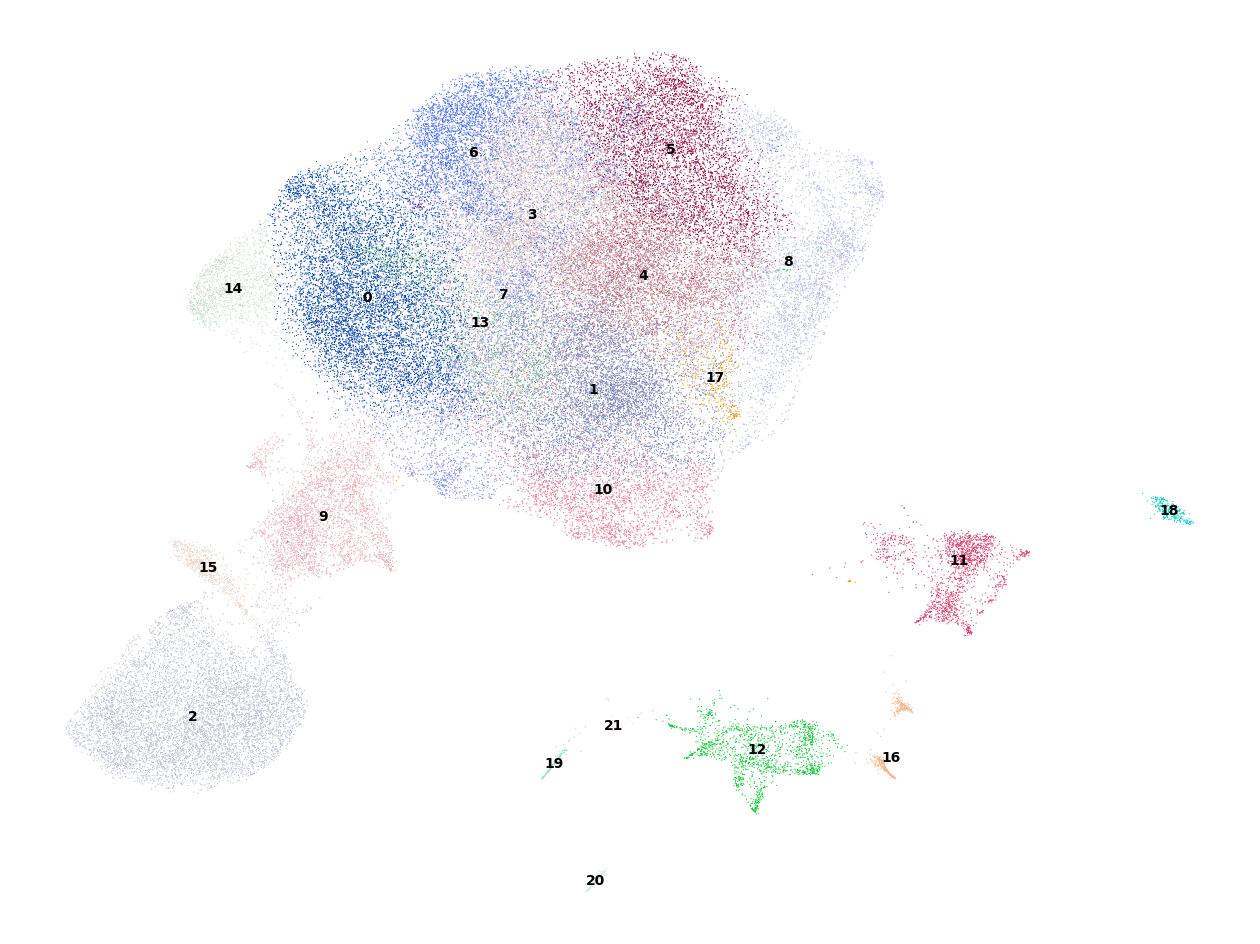

In [25]:
# View UMAP plot
mpl.rcParams["figure.figsize"] = (16, 12)
sc.pl.umap(adata, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "", size = 3)

## Add subject information from SoupOrCell
Library_5J_0421 has cells from two subjects. SoupOrCell was run on it. Cluster 0 is HV11 and cluster 1 is HV12.

In [26]:
soc_ids = pd.read_csv(f'{data_dir}/NEP_exon_only/Library_5J_0421/Library_5J_0421_soc_clusters.tsv', sep = '\t')
soc_ids

,barcode,status,assignment,log_prob_singleton,log_prob_doublet,cluster0,cluster1
0,AAACCTGAGAAACGAG-1,singlet,1,-62.797416,-93.845886,-255.183408,-62.797416
1,AAACCTGAGCTTTGGT-1,singlet,0,-73.705704,-106.235717,-73.705704,-328.189776
2,AAACCTGAGGATCGCA-1,singlet,1,-58.318809,-90.556472,-222.484085,-58.318809
3,AAACCTGAGTCGTACT-1,singlet,1,-49.363109,-98.974581,-271.459861,-49.363109
4,AAACCTGCAAACCTAC-1,singlet,0,-61.154155,-93.421656,-61.154155,-301.897856
...,...,...,...,...,...,...,...
6140,TTTGTCAGTCACCCAG-1,singlet,0,-32.352418,-55.909801,-32.352418,-165.417859
6141,TTTGTCAGTCCCTTGT-1,singlet,1,-13.925109,-22.445916,-52.519030,-13.925109
6142,TTTGTCAGTGCTTCTC-1,singlet,0,-54.206767,-81.800107,-54.206767,-210.560638
6143,TTTGTCATCACCCGAG-1,singlet,1,-80.198866,-123.472701,-326.183686,-80.198866


In [27]:
soc_ids.groupby(['status', 'assignment']).size()

status      assignment
doublet     0/1             85
            1/0             71
singlet     0             3298
            1             2665
unassigned  0                2
            0/1             15
            1                2
            1/0              7
dtype: int64

In [28]:
# Only keep singlets
soc_ids = soc_ids[soc_ids["status"] == "singlet"].copy()
soc_ids["barcode_mod"] = soc_ids["barcode"].apply(lambda x: x + '-Library_5J_0421')

In [29]:
# Change study IDs of singlets
c0bc = soc_ids[soc_ids["assignment"] == '0']['barcode_mod']
c1bc = soc_ids[soc_ids["assignment"] == '1']['barcode_mod']
adata.obs["Study ID"][adata.obs_names.isin(c0bc)] = "HV11"
adata.obs["Study ID"][adata.obs_names.isin(c1bc)] = "HV12"

# Remove unassigned/doublet cells from dataset
adata = adata[adata.obs["Study ID"] != "HV11/HV12"]

In [30]:
adata

View of AnnData object with n_obs × n_vars = 71474 × 1000
    obs: 'Study ID', 'is_PASC', 'SC ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'SC ID_colors', 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_scVI_colors'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

## Cluster composition

In [ ]:
mpl.rcParams["figure.figsize"] = (18, 5)
pplt = sc_utils.plot_composition(adata, group_by = "leiden_scVI", color = "Study ID")
pplt.legend(loc = "lower right", ncol = 5);

In [ ]:
mpl.rcParams["figure.figsize"] = (18, 5)
pplt = sc_utils.plot_composition(adata, group_by = "Study ID", color = "leiden_scVI")
pplt.legend(ncol = 3);

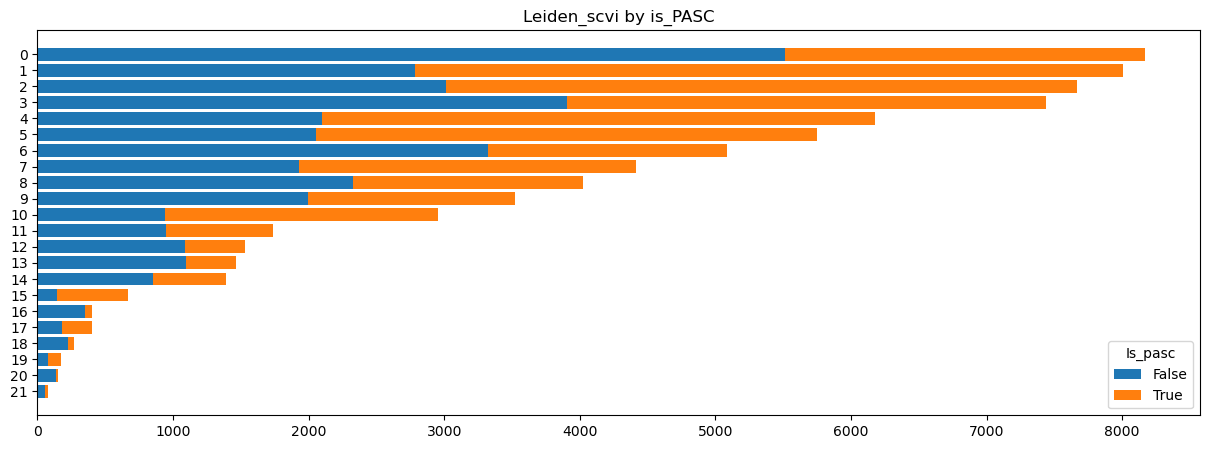

In [33]:
mpl.rcParams["figure.figsize"] = (15, 5)
sc_utils.plot_composition(adata, group_by = "leiden_scVI", color = "is_PASC");

## Perform QC

In [34]:
sc.pp.calculate_qc_metrics(adata, percent_top = None, log1p = False, inplace = True)

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


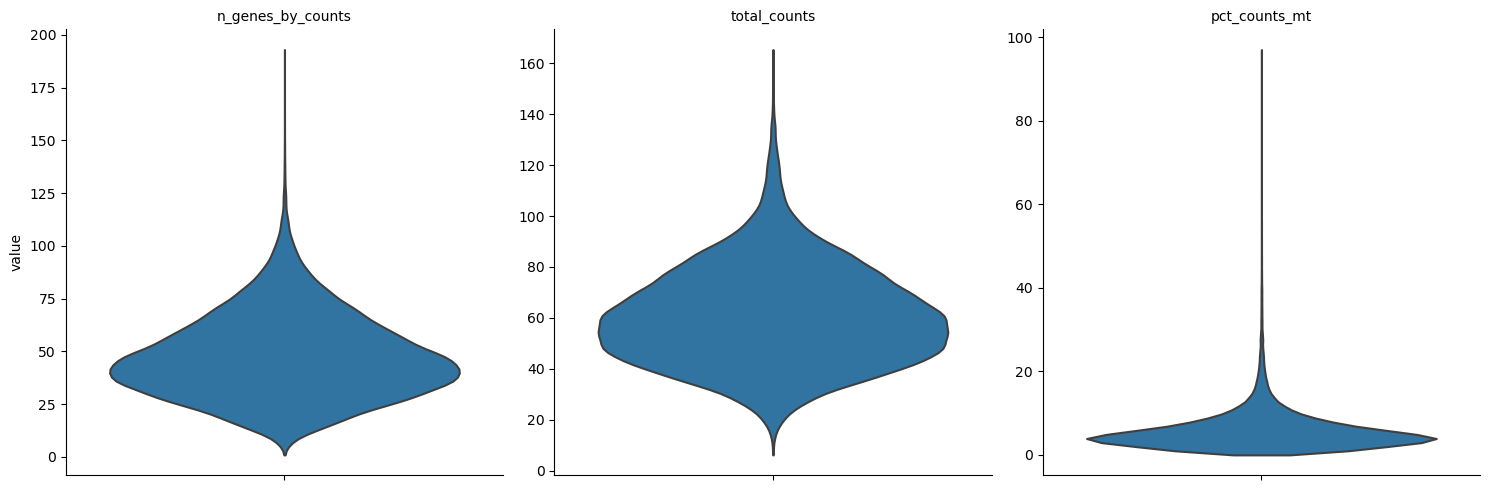

In [35]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             multi_panel = True, stripplot = False)

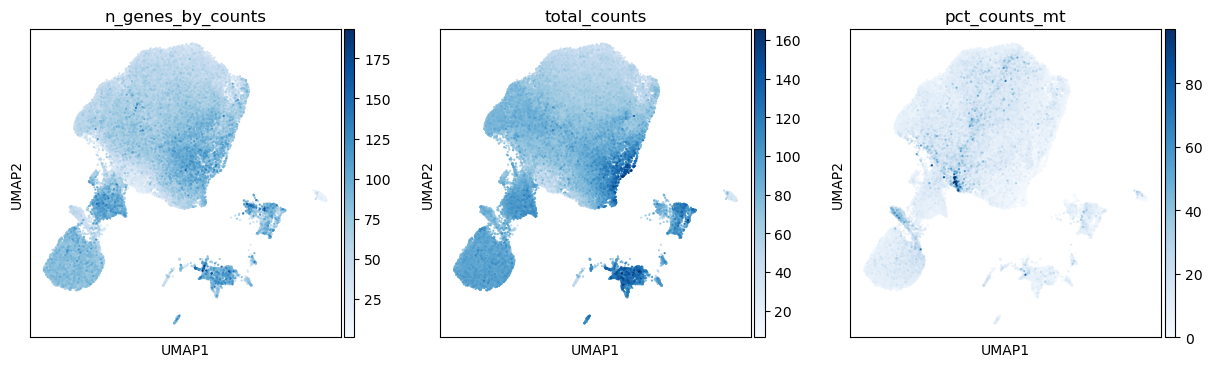

In [36]:
mpl.rcParams["figure.figsize"] = (15, 4)
fig, ax = plt.subplots(1, 3)

sc.pl.umap(adata, color = ['n_genes_by_counts'], legend_loc = "on data",
           size = 10, ncols = 2, cmap = 'Blues', show = False, ax = ax[0])
sc.pl.umap(adata, color = ['total_counts'], legend_loc = "on data",
           size = 10, ncols = 2, cmap = 'Blues', show = False, ax = ax[1])
sc.pl.umap(adata, color = ['pct_counts_mt'], legend_loc = "on data",
           size = 10, ncols = 2, cmap = 'Blues', show = False, ax = ax[2]);

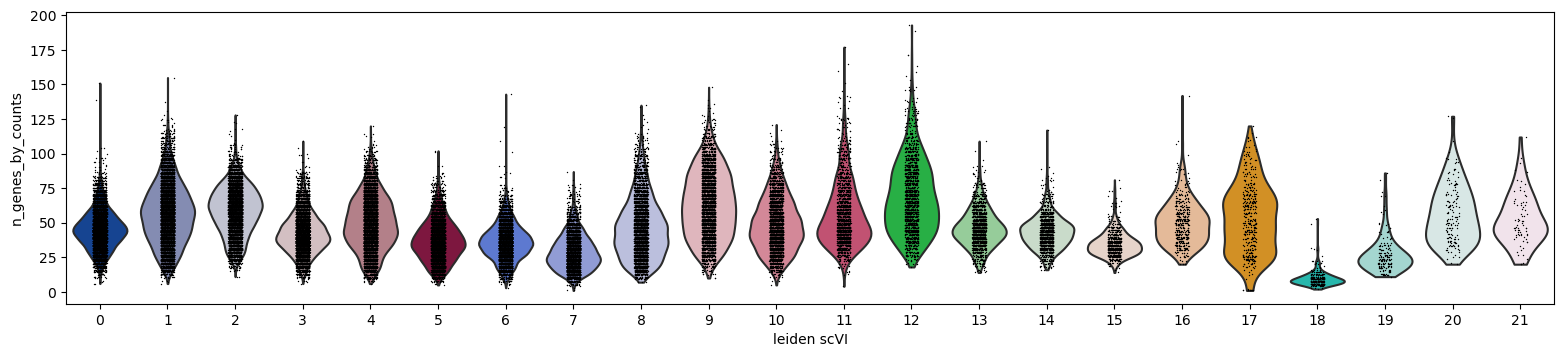

In [37]:
sc.pl.violin(adata, "n_genes_by_counts", groupby = "leiden_scVI")

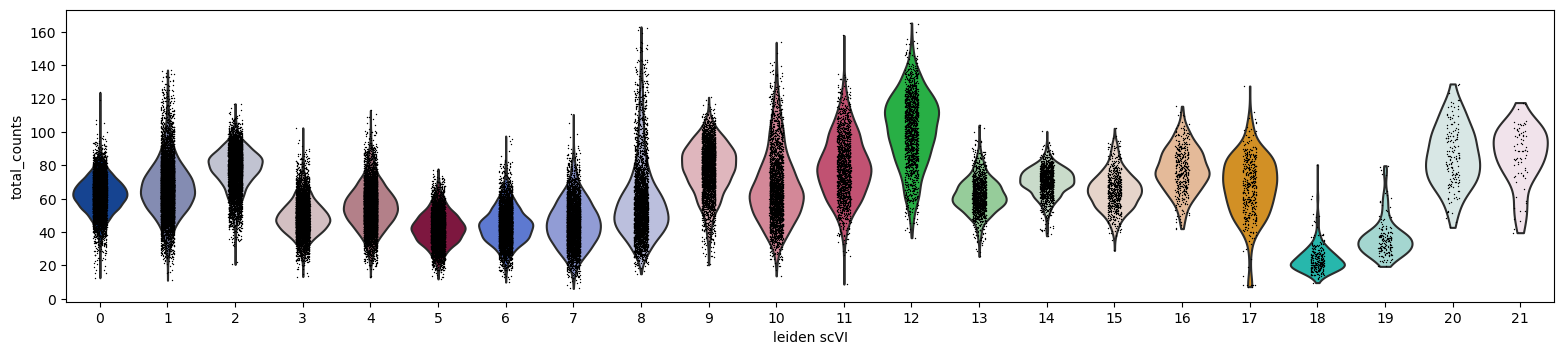

In [38]:
sc.pl.violin(adata, "total_counts", groupby = "leiden_scVI")

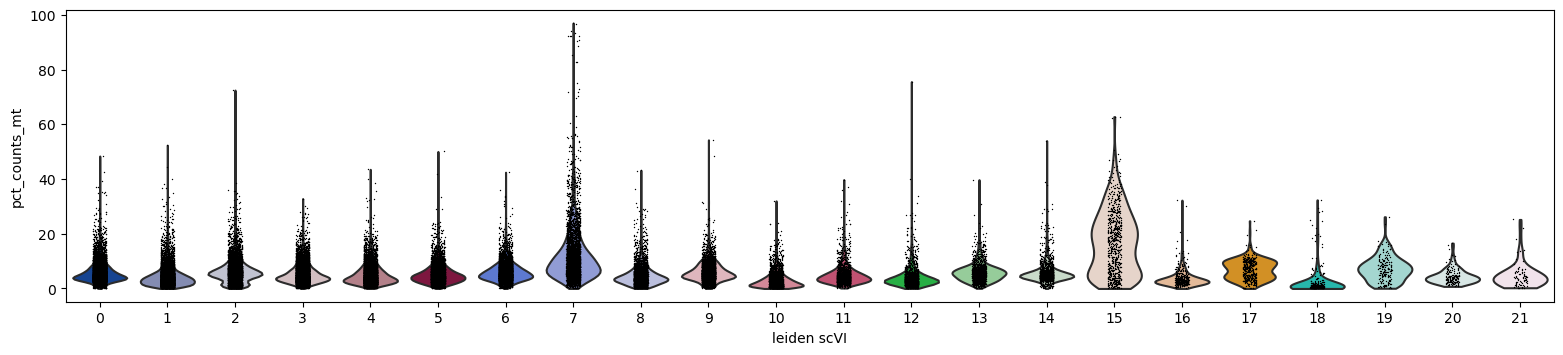

In [39]:
sc.pl.violin(adata, "pct_counts_mt", groupby = "leiden_scVI")

In [42]:
adata.obs["subcluster"] = adata.obs.leiden_scVI

In [44]:
def recluster(ad, res, ix):
    sc.tl.leiden(ad, key_added = "subcluster", resolution = res)
    cats = ad.obs["subcluster"].cat
    ad.obs["subcluster"] = cats.rename_categories({c: str(ix) + '-' + c for c in cats.categories})

### Resolve cluster 8

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


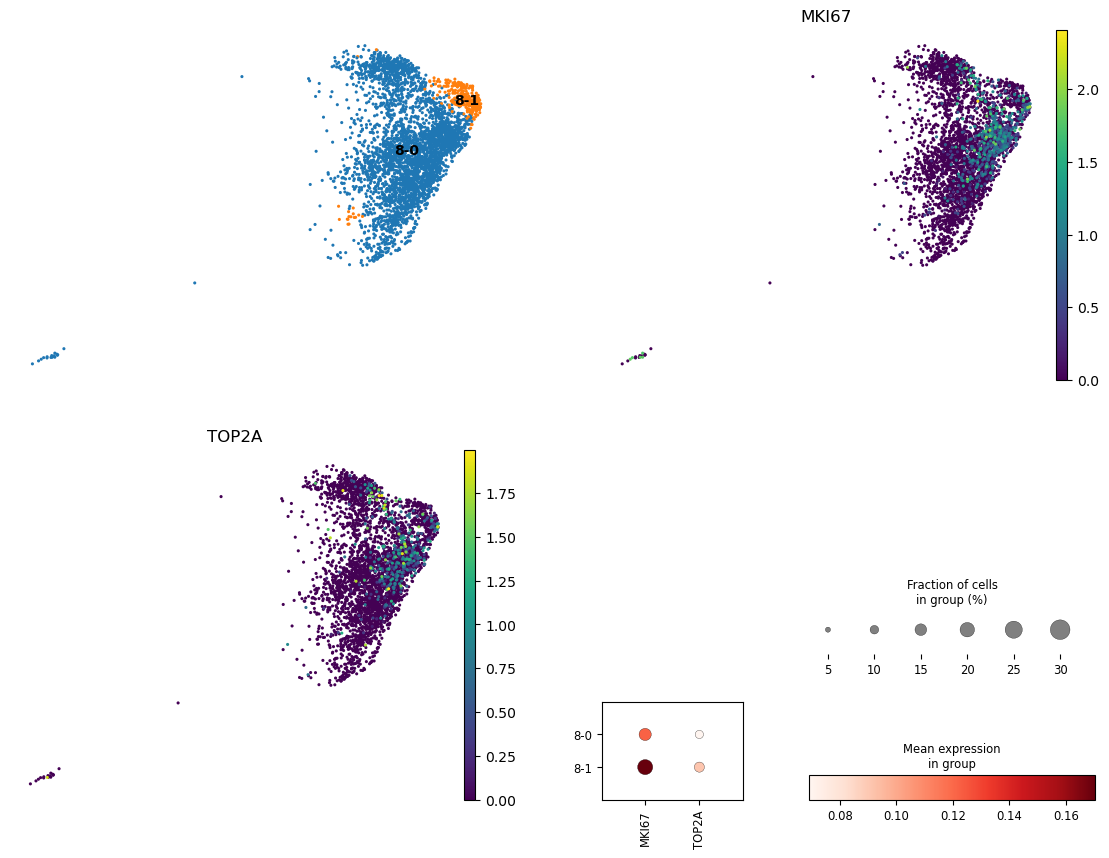

In [46]:
ix = '8'
adata_sub = adata[adata.obs["leiden_scVI"] == ix].copy()
recluster(adata_sub, 0.1, ix)

mpl.rcParams["figure.figsize"] = (14, 10)
fig, ax = plt.subplots(2, 2)
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "",
           size = 20, show = False, ax = ax[0][0])
sc.pl.umap(adata_sub, color = "MKI67", legend_loc = "on data", frameon = False, title = "MKI67",
           size = 20, show = False, ax = ax[0][1])
sc.pl.umap(adata_sub, color = "TOP2A", legend_loc = "on data", frameon = False, title = "TOP2A",
           size = 20, show = False, ax = ax[1][0])
sc.pl.dotplot(adata_sub, ["MKI67", "TOP2A"], groupby = "subcluster", ax = ax[1][1])

In [47]:
adata.obs.update(adata_sub.obs)

### Resolve cluster 11

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


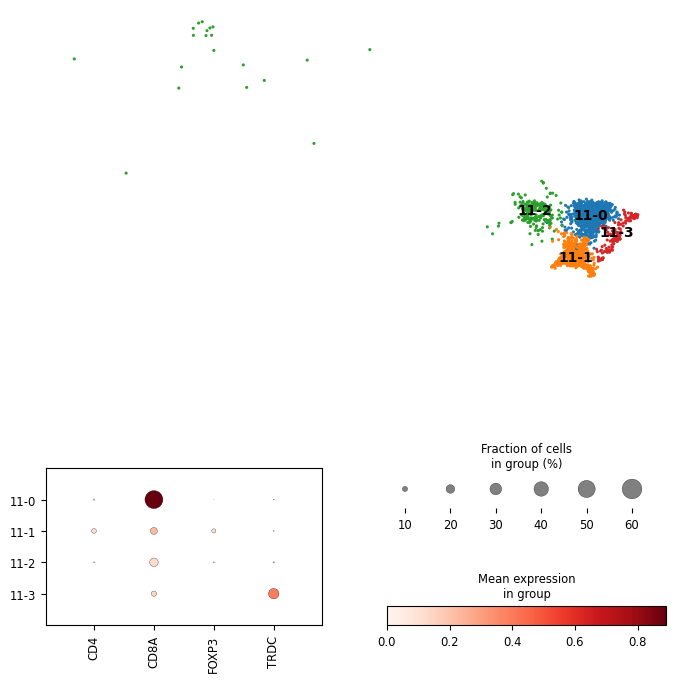

In [50]:
ix = '11'
adata_sub = adata[adata.obs["leiden_scVI"] == ix].copy()
recluster(adata_sub, 0.25, ix)

mpl.rcParams["figure.figsize"] = (8, 8)
fig, ax = plt.subplots(2, 1)
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "",
           size = 20, show = False, ax = ax[0])
sc.pl.dotplot(adata_sub, ["CD4", "CD8A", "FOXP3", "TRDC"], groupby = "subcluster", ax = ax[1])

In [51]:
adata.obs.update(adata_sub.obs)

### Resolve cluster 12

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


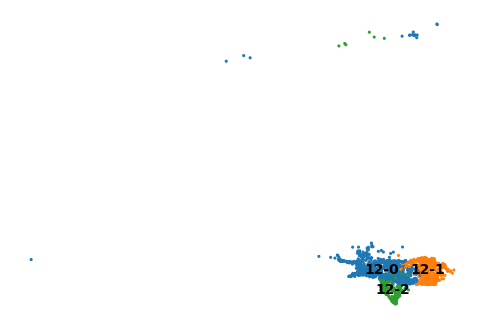

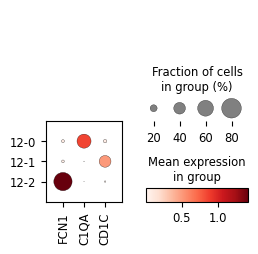

In [52]:
ix = '12'
adata_sub = adata[adata.obs["leiden_scVI"] == ix].copy()
recluster(adata_sub, 0.1, ix)

mpl.rcParams["figure.figsize"] = (6, 4)
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "",
           size = 20, show = False)
sc.pl.dotplot(adata_sub, ["FCN1", "C1QA", "CD1C"], groupby = "subcluster")

In [53]:
adata.obs.update(adata_sub.obs)

### Resolve cluster 16

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


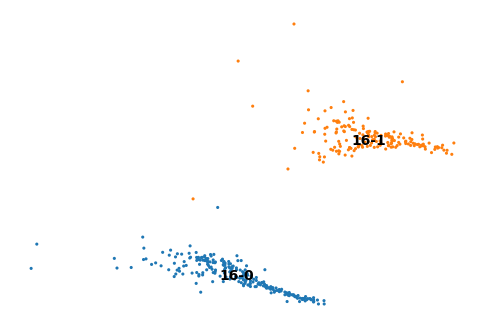

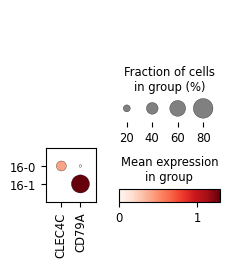

In [55]:
ix = '16'
adata_sub = adata[adata.obs["leiden_scVI"] == ix].copy()
recluster(adata_sub, 0.1, ix)

mpl.rcParams["figure.figsize"] = (6, 4)
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "",
           size = 20, show = False)
sc.pl.dotplot(adata_sub, ["CLEC4C", "CD79A"], groupby = "subcluster")

In [56]:
adata.obs.update(adata_sub.obs)

## Find marker genes

In [58]:
sc.tl.rank_genes_groups(adata, "subcluster", method = "wilcoxon", n_genes = 200)

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performanc

In [59]:
markers = sc_utils.get_markers(adata, "subcluster")
pd.options.display.max_rows = 200
markers.groupby("cluster").apply(lambda x: x.sort_values("avg_logFC", ascending = False).head(5))

p_val  avg_logFC     pct.1     pct.2      p_val_adj  \
cluster                                                                     
0       2      0.000000e+00   4.191031  0.892726  0.214333   0.000000e+00   
        3      0.000000e+00   3.955569  0.886481  0.199485   0.000000e+00   
        0      0.000000e+00   3.574196  0.998163  0.663439   0.000000e+00   
        11     0.000000e+00   3.488049  0.620132  0.141009   0.000000e+00   
        22     0.000000e+00   3.458096  0.506123  0.116447   0.000000e+00   
1       340   1.686891e-238   4.066095  0.251999  0.027162  1.686891e-238   
        223    0.000000e+00   3.799785  0.450775  0.052970   0.000000e+00   
        299   3.377284e-284   3.489105  0.277111  0.030172  3.377284e-284   
        200    0.000000e+00   3.120808  0.837581  0.295730   0.000000e+00   
        252    0.000000e+00   2.987672  0.369440  0.061557   0.000000e+00   
10      2212   0.000000e+00   6.213059  0.644572  0.024972   0.000000e+00   
        2395  2.673605e-135   5.853516  0.281704  0.013354  2.673605e-135   
        2244   0.000000e+00   5.468719  0.496111  0.034050   0.000000e+00   
        2241   0.000000e+00   5.320174  0.496111  0.023994   0.000000e+00   
        2397  9.834075e-135   5.271502  0.280690  0.011939  9.834075e-135   
11-0    2400   0.000000e+00  10.254685  0.964109  0.008278   0.000000e+00   
        2491   3.054713e-59   9.604582  0.337871  0.001146   3.054713e-59   
        2440  6.641277e-147   9.029099  0.533416  0.002547  6.641277e-147   
        2427  2.065139e-183   8.868646  0.596535  0.003269  2.065139e-183   
        2532   9.720771e-30   8.459233  0.238861  0.001203   9.720771e-30   
11-1    2798   1.545563e-08   8.802616  0.156673  0.000465   1.545563e-08   
        2655   5.094191e-82   7.385377  0.500967  0.005806   5.094191e-82   
        2657   4.615931e-79   7.014606  0.493230  0.007948   4.615931e-79   
        2623  6.247364e-139   6.931058  0.655706  0.011415  6.247364e-139   
        2792   2.160361e-09   6.888661  0.166344  0.002213   2.160361e-09   
11-2    2800   1.242511e-58   4.835366  0.646091  0.016945   1.242511e-58   
        2810   1.554952e-17   4.046876  0.362140  0.010852   1.554952e-17   
        2888   1.688782e-05   3.881931  0.209877  0.007104   1.688782e-05   
        2824   7.391732e-12   3.775185  0.300412  0.008985   7.391732e-12   
        2804   5.898145e-25   3.767542  0.432099  0.014657   5.898145e-25   
11-3    3094   8.718403e-12  10.429178  0.329412  0.000547   8.718403e-12   
        3016   4.146930e-38  10.307690  0.594118  0.002903   4.146930e-38   
        3084   1.754329e-13   9.804111  0.352941  0.001066   1.754329e-13   
        3122   2.487165e-07   9.801675  0.258824  0.000519   2.487165e-07   
        3151   3.140656e-05   8.971173  0.217647  0.001136   3.140656e-05   
12-0    3234  1.693905e-134  11.041438  0.511860  0.000976  1.693905e-134   
        3227  2.818501e-161  10.932407  0.560549  0.001245  2.818501e-161   
        3235  7.196392e-132  10.902403  0.506866  0.000990  7.196392e-132   
        3367   4.417185e-23  10.758122  0.210986  0.000170   4.417185e-23   
        3268   1.207120e-62   9.634738  0.349563  0.000990   1.207120e-62   
12-1    3518   9.198098e-51   9.177876  0.404564  0.001183   9.198098e-51   
        3572   9.779918e-34   8.421659  0.329876  0.001549   9.779918e-34   
        3400  4.157573e-300   8.040504  0.991701  0.077685  4.157573e-300   
        3510   1.299559e-53   7.928596  0.417012  0.002282   1.299559e-53   
        3483   1.506205e-75   7.893737  0.495851  0.003465   1.506205e-75   
12-2    3617   2.247947e-84  10.806880  0.726908  0.001516   2.247947e-84   
        3607  9.815619e-111   7.875714  0.839357  0.013254  9.815619e-111   
        3779   1.567406e-10   7.787095  0.257028  0.002569   1.567406e-10   
        3640   8.339234e-55   7.577872  0.590361  0.010165   8.339234e-55   
        3602  1.802174e-138   7.542854  0.943775  0.023292  1.802174e-138   
13      3855   2.0

## Save output

In [60]:
out_dir = "01NEP/01integrated_NEP_v1"
out_name = "01integrated_NEP_v1"

In [61]:
adata.write(f"{data_dir}/{out_dir}/{out_name}.h5ad")
adata.obs.to_csv(f"{data_dir}/{out_dir}/{out_name}-metadata.csv")
markers.to_csv(f"{data_dir}/{out_dir}/{out_name}-markers.csv")